# Assignment 5.3
#Library Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


#Data loading

In [4]:
# Load cleaned dataset
df = pd.read_csv("motioniq_cleaned_dataset.csv")

#Pre Processing


In [7]:
#Handle the 'nan' value and rare classes
activity_counts = df['activity'].value_counts(dropna=False)
rare_activities = activity_counts[activity_counts < 2].index

if len(rare_activities) > 0:
    print(f"Removing rare/null activities to allow stratification: {list(rare_activities)}")
    # Drop rows where activity is in the rare_activities list or is NaN
    df = df[df['activity'].isin(activity_counts[activity_counts >= 2].index)]
    df = df.dropna(subset=['activity'])

# Define features (X) and target (y)
X = df.drop(columns=['subject', 'activity_id', 'activity', 'timestamp', 'datetime'], errors='ignore')
y = df['activity']

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# 4. Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Successfully split data into {X_train.shape[0]} training and {X_test.shape[0]} testing samples.")

Removing rare/null activities to allow stratification: [nan]
Successfully split data into 888 training and 222 testing samples.


#Fully Connected Neural Network construction

In [8]:


class FCNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCNNModel, self).__init__()
        # 2-4 hidden layers
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2), # Helps prevent overfitting
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes) Softmax is applied by CrossEntropyLoss
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
model = FCNNModel(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:

# Convert the scaled NumPy arrays to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print("Data successfully converted to Tensors.")
print(f"Train Tensor Shape: {X_train_t.shape}")
print(f"Test Tensor Shape: {X_test_t.shape}")

Data successfully converted to Tensors.
Train Tensor Shape: torch.Size([888, 561])
Test Tensor Shape: torch.Size([222, 561])


#Training loop

In [11]:
epochs = 50
train_losses = []
val_losses = []

print("Starting Training...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation phase for loss curves
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

print("Training Complete!")

Starting Training...
Epoch [1/50], Loss: 1.7912, Val Loss: 1.6534
Epoch [10/50], Loss: 0.5078, Val Loss: 0.4253
Epoch [20/50], Loss: 0.1337, Val Loss: 0.1735
Epoch [30/50], Loss: 0.0492, Val Loss: 0.1343
Epoch [40/50], Loss: 0.0233, Val Loss: 0.1157
Epoch [50/50], Loss: 0.0065, Val Loss: 0.1083
Training Complete!


#Evaluation, Plots & comparison

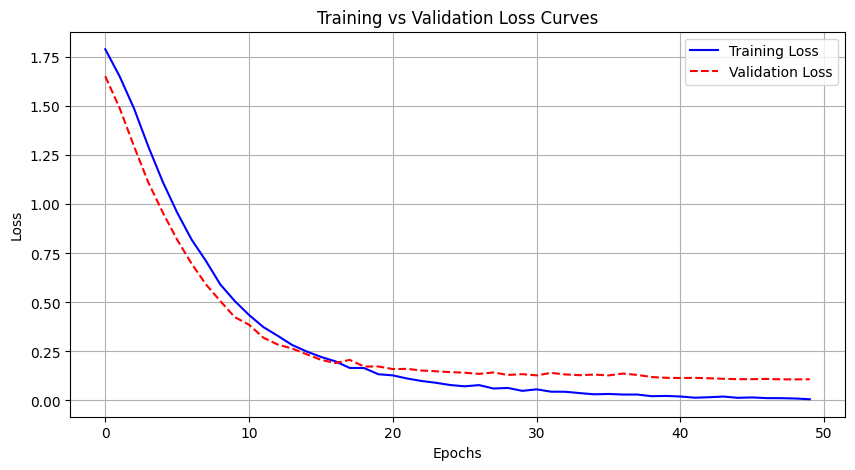

In [16]:

#  Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--')
plt.title('Training vs Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [13]:
#Final Predictions
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)
    _, predicted = torch.max(test_outputs, 1)
    y_pred = predicted.numpy()

print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Final F1-Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")

Final Test Accuracy: 95.95%
Final F1-Score (Weighted): 0.9595


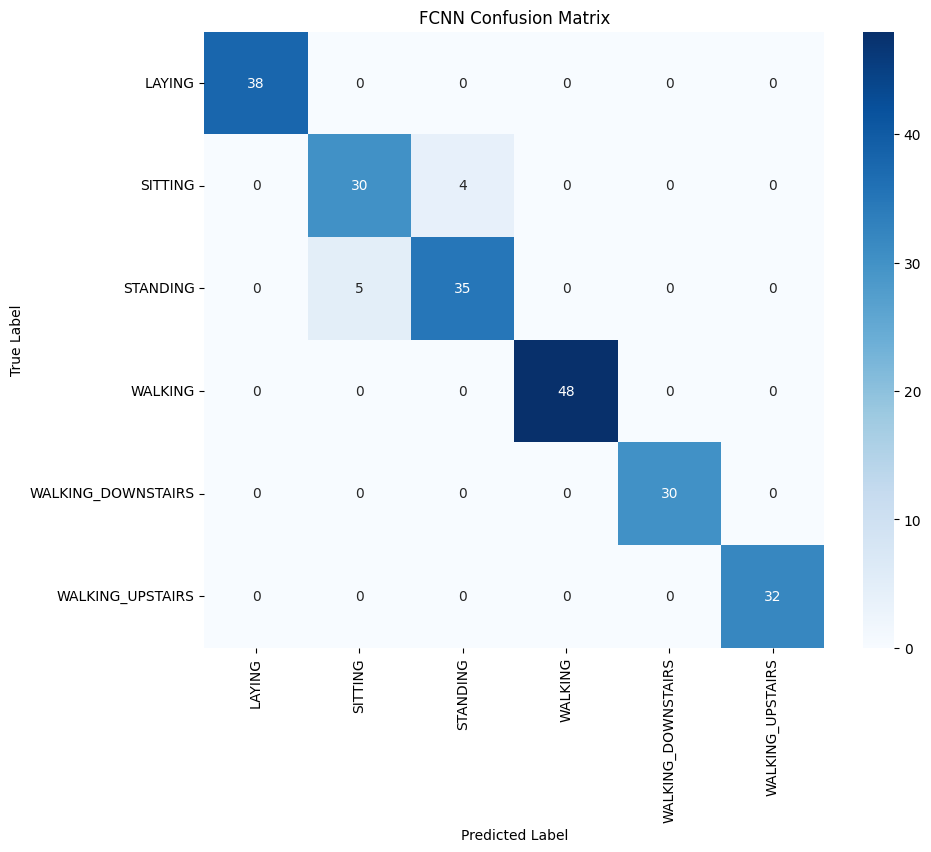

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('FCNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()